# London Data - Part 1: Numbers

This is a supplement to my article series about rental prices in London, in which I scraped the web for a bunch of data to play around with. The full investigation is here http://www.callumlamont.com/considerations2/london-numbers

### The data

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.stretch"] = 'expanded'
plt.rcParams["font.weight"] = 'medium'
plt.axes.linewidth = 2

df = pd.read_json('data.json')
print('Shape of the data: ', df.shape)  # .json file contains > 27,000 listings each with 38 data points
print('\nThere are many things we could start looking into with this...\n')
df.head(3)

Shape of the data:  (27843, 38)

There are many things we could start looking into with this...



,ID,advertiser,average_rent,balcony_patio,benefits,bills_included,broadband,couples,deposit,description,...,parking,pets,postcode,property_type,references,room_no,smokers,suburb,title,train_distance
0,9341566,agent,600.0,No,No,Yes,Yes,No,0,\n ***NO ADMIN FEES***Come ...,...,Yes,No,SE2,house,Yes,5,Yes,Abbey Wood,Newly Refurbished HouseShare - Great Transport!,5.0
1,3933359,live out landlord,550.0,No,No,Yes,No,No,550,\n A GOOD SIZE DOUBLE ROOM ...,...,Yes,No,SE2,house,No,4,Yes,Abbey Wood,Master Bedroom Available - Bills Inclusive,5.0
2,9089446,agent,440.0,Yes,No,Yes,Yes,No,420,\n Your search for the idea...,...,No,No,SE2,flat,Yes,4,No,Abbey Wood,Double Room close to Abbey Wood Train Station!,5.0


### The basics

/Users/cal_lamont/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


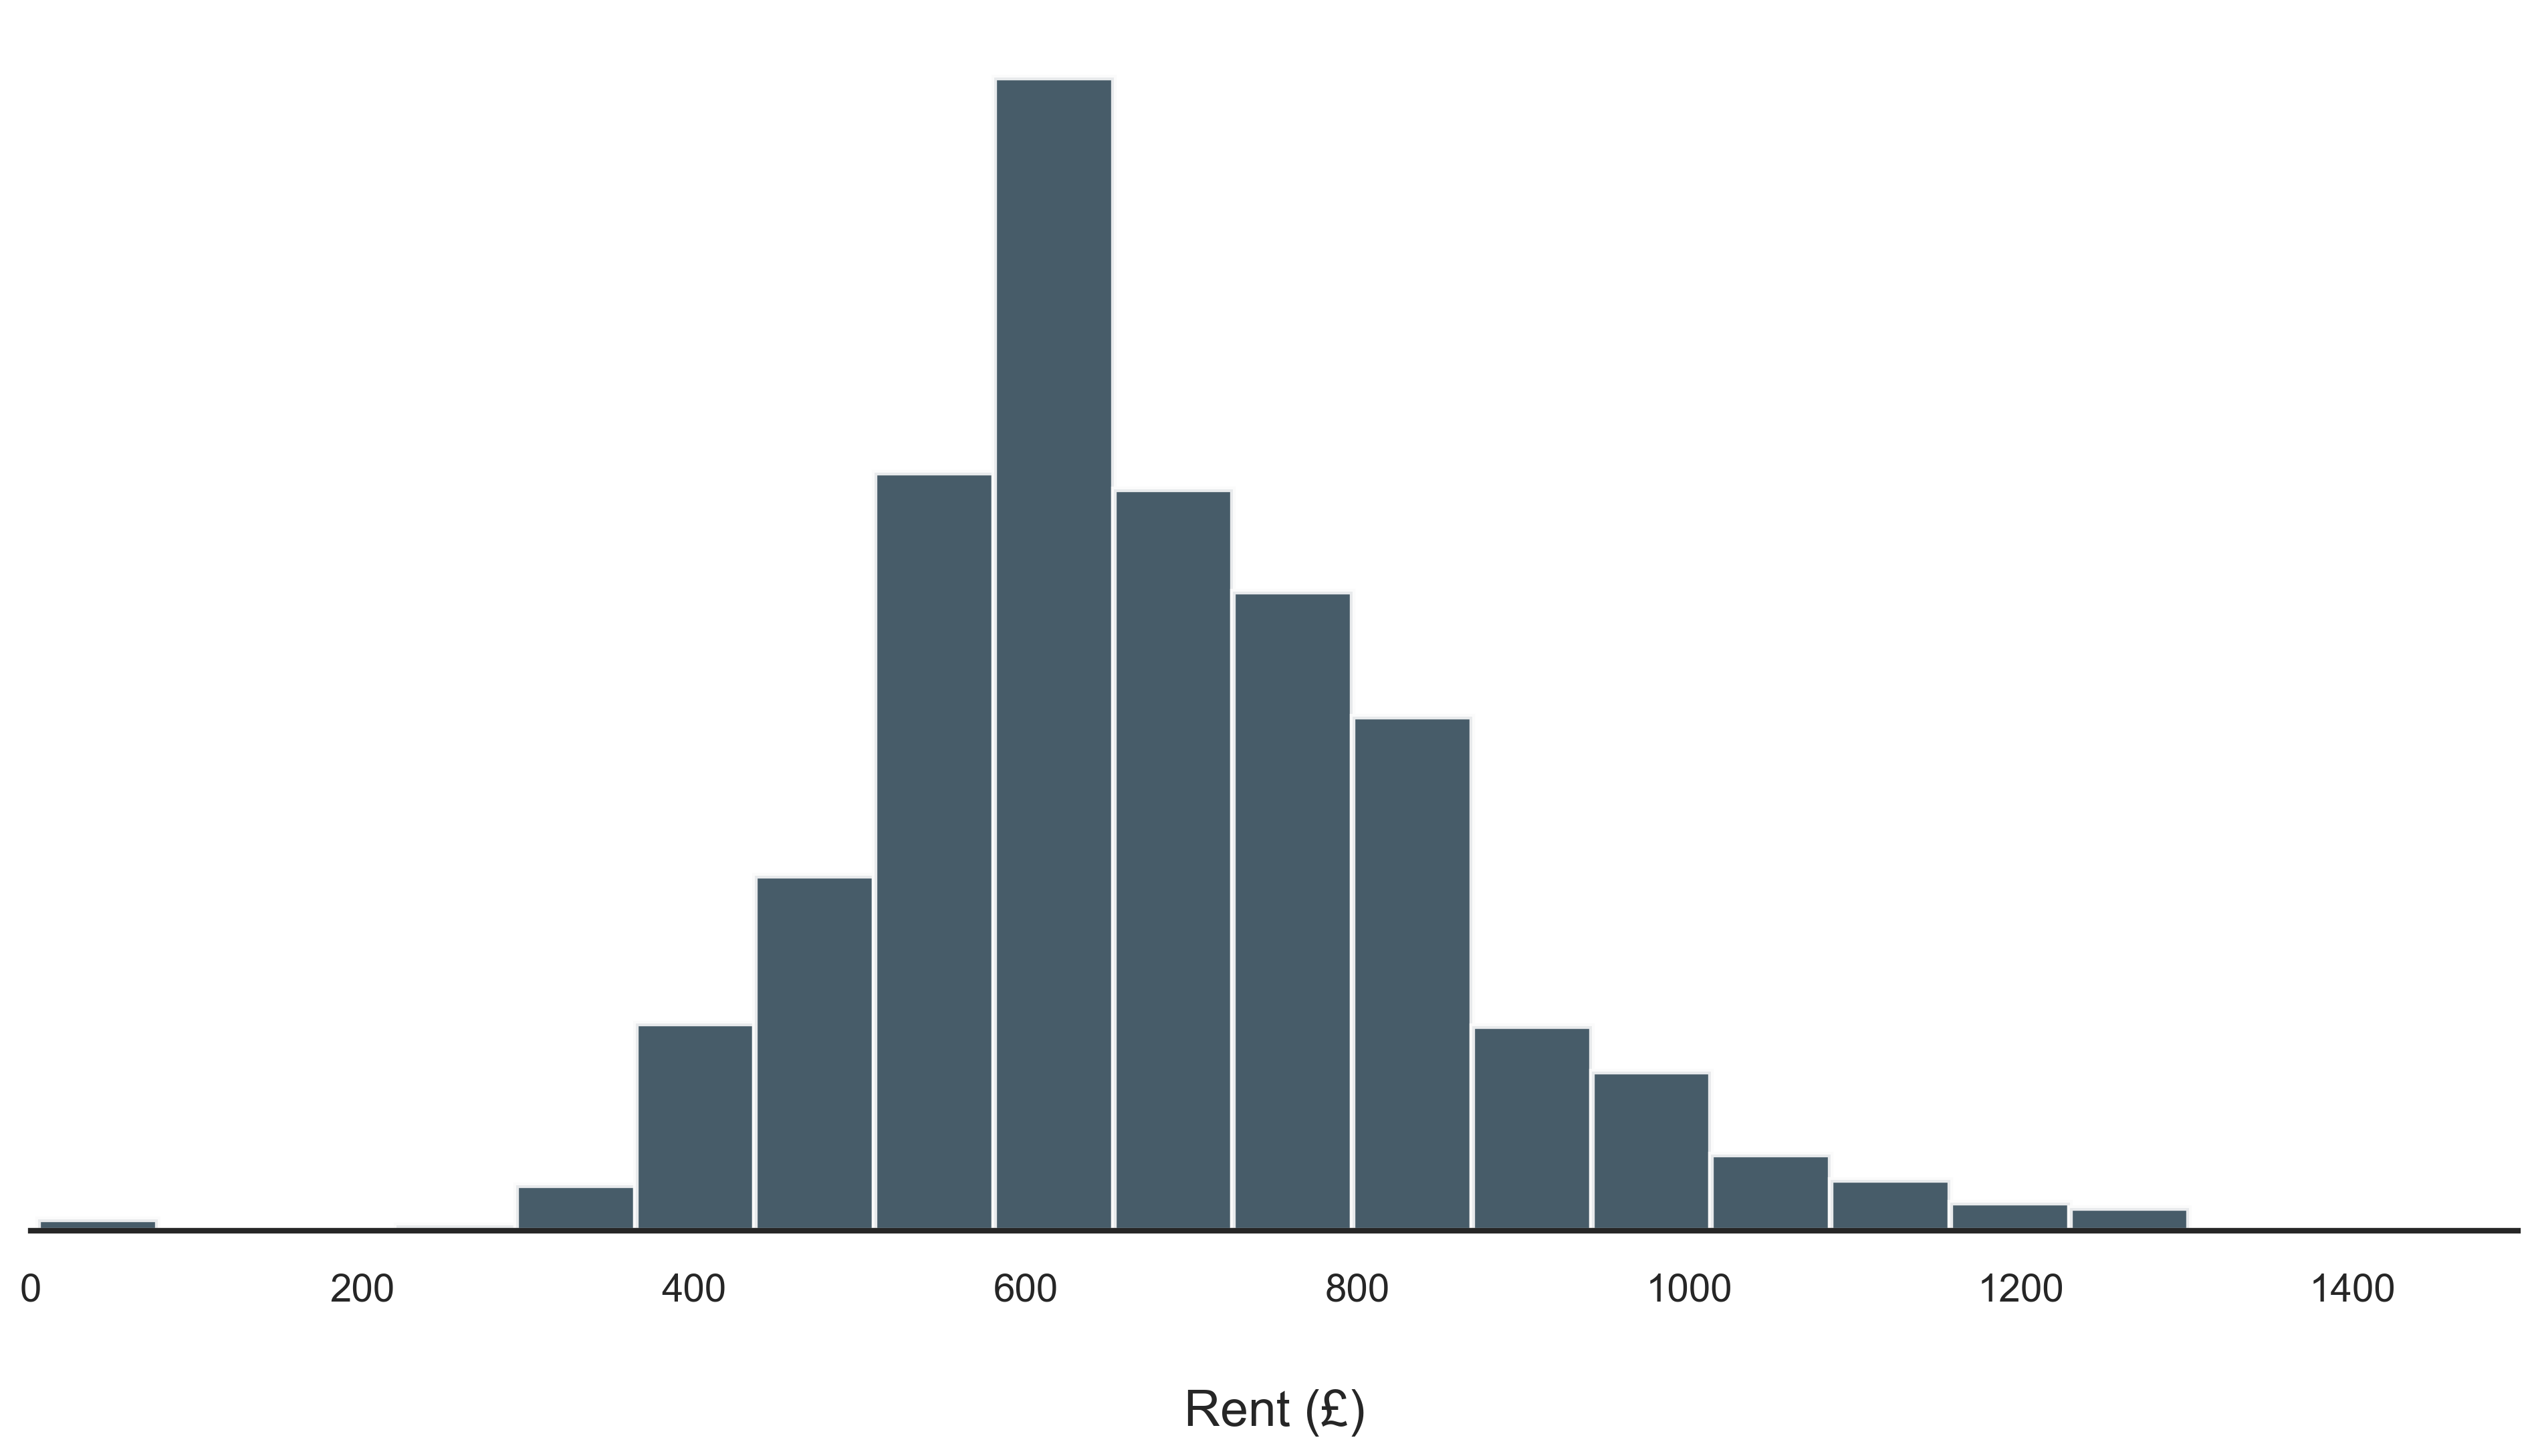

In [7]:
# What is the average rent of the.. average rent of the listings.
# (Some listings had multiple rooms advertised)
ave_rent = df['average_rent'].mean()
med_rent = df['average_rent'].median()

df_cheap = df[df['average_rent']<3000].dropna()  # Ignore expensive flats skewing the data

fig,ax = plt.subplots(figsize=(16,8), dpi=300)
sns.distplot(df_cheap['average_rent'], color = (0.2,0.29,0.35), ax=ax, kde=False, bins=30, hist_kws=dict(alpha=0.9, edgecolor=(0.984,0.984,0.984), linewidth=2))

ax.set_xlabel('Rent (£)', fontsize=18)
ax.tick_params(labelsize=14)
ax.xaxis.set_label_coords(0.5, -0.13)
plt.gca().axes.tick_params(pad=15)
ax.spines['bottom'].set_linewidth(2)
ax.set_xlim(0,1500)

ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

/Users/cal_lamont/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/cal_lamont/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


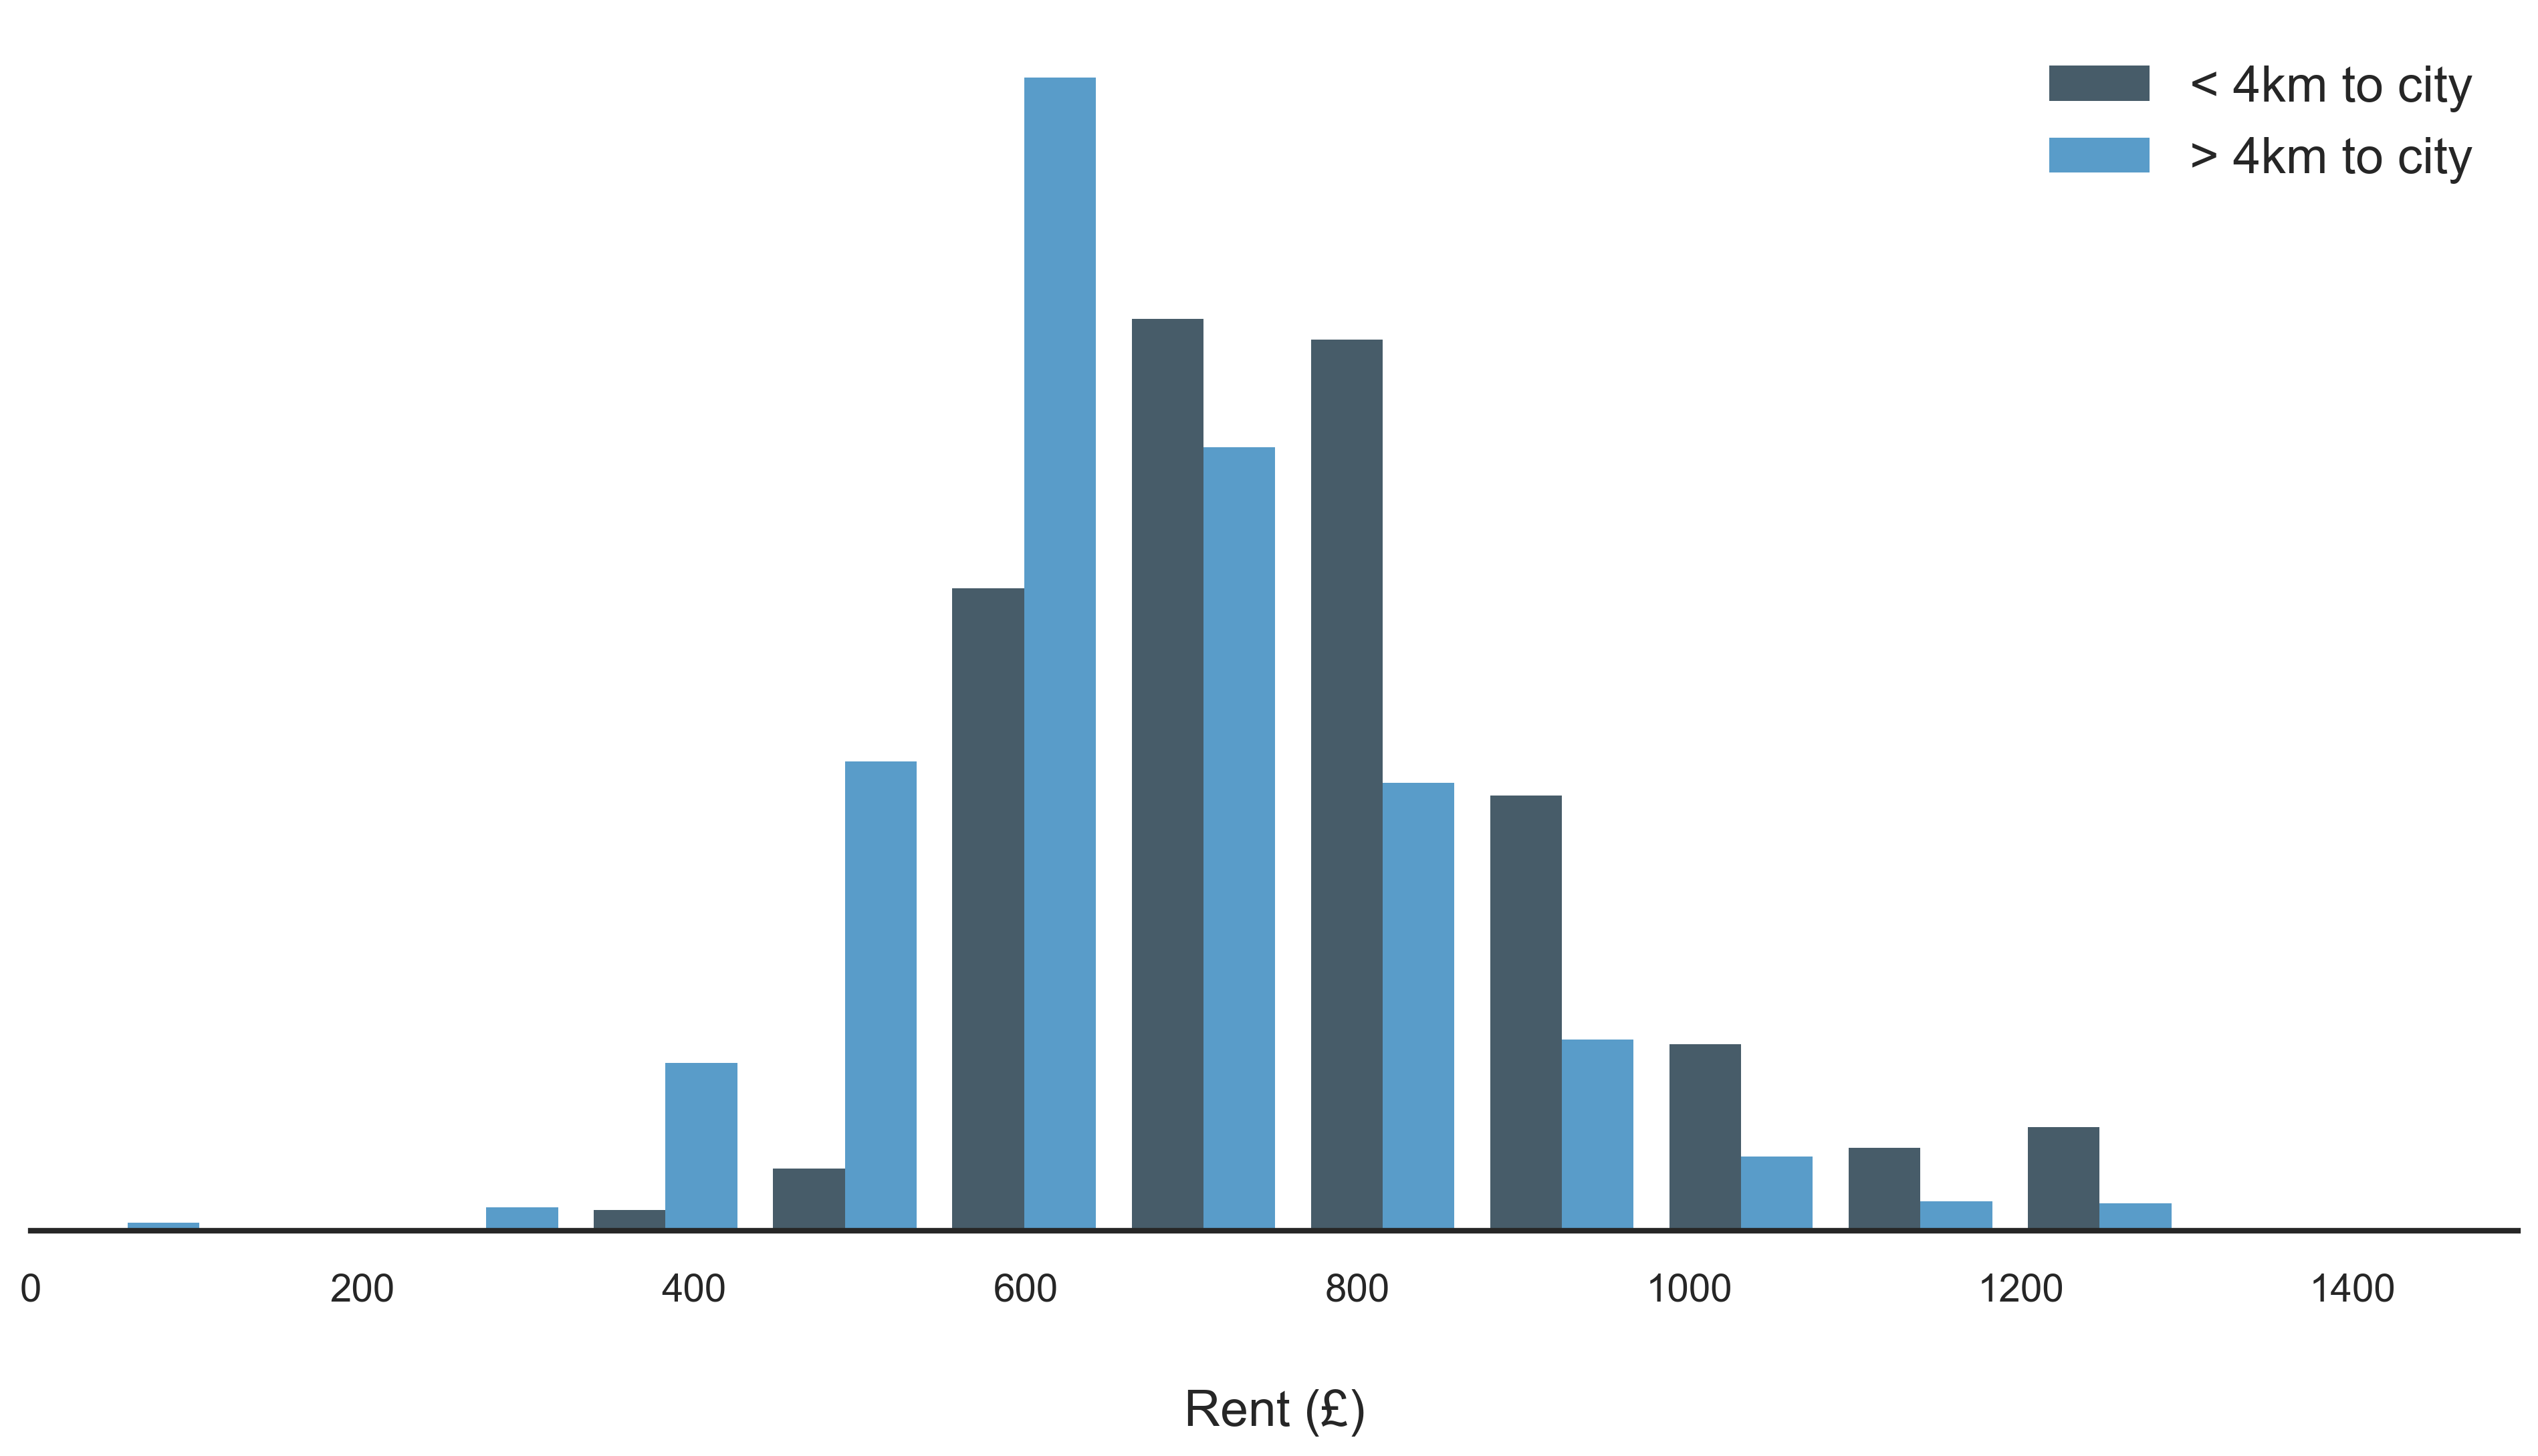

In [3]:
# How does the rent vary with distance to the city centre
# Use postcodes as a proxy to distance from city centre
postcode_distances = pd.read_csv('postcode_distances.csv', header=None, index_col=0)
def get_distance(col):
    return postcode_distances.loc[col]

df['distance_to_city'] = df['postcode'].apply(get_distance)
df_close = df[df['distance_to_city']<4].dropna()
df_far = df[df['distance_to_city']>4].dropna()

ax = plt.figure(figsize=(16,8), dpi=300)
ax = plt.hist([df_close['average_rent'], df_far['average_rent']], color=[(0.2,0.29,0.35),(0.28,0.57,0.77)], normed=True, bins=20, alpha=0.9,edgecolor="w", linewidth=0)
plt.xlim(0,1500)
plt.xlabel('Rent (£)', fontsize=18)

plt.gca().yaxis.set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tick_params(labelsize=14)
plt.gca().xaxis.set_label_coords(0.5, -0.13)
plt.gca().axes.tick_params(pad=15)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().legend(['< 4km to city', '> 4km to city'], fontsize=18)

plt.savefig('rent_hist.png', dpi=600, transparent=True)

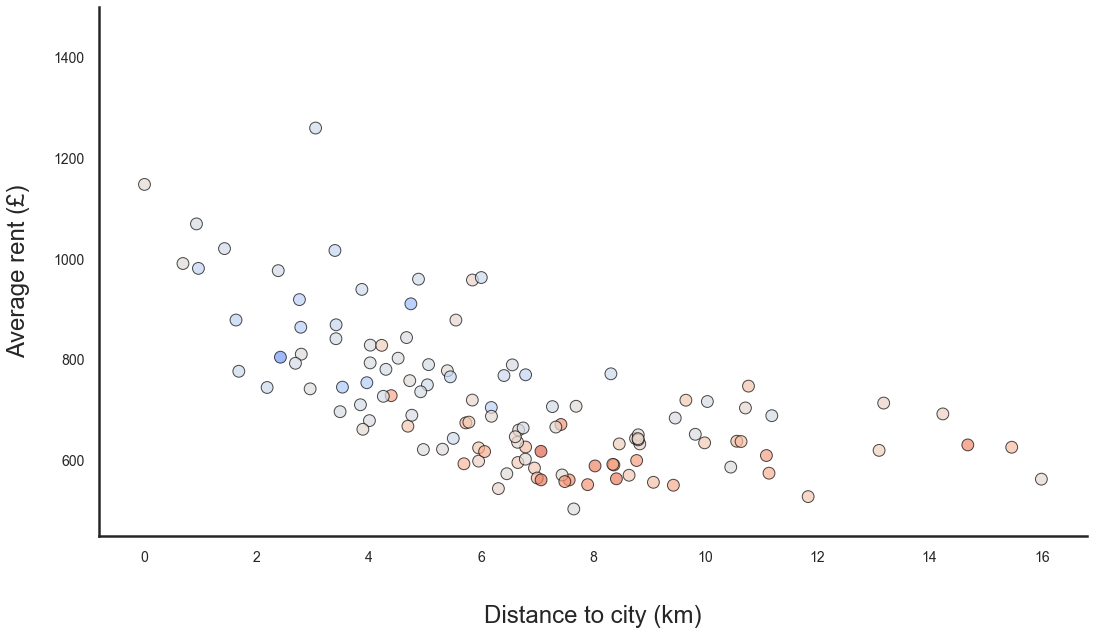

In [9]:
# Scatter plot of average rent as a function of distance to the city centre
# Redder points indicate an older average age of existing tenants
import re

def get_flatmate_ages(age_range): 
    try:
        ages = re.search(r'(\d\d)to(\d\d)', age_range)  
        youngest = int(ages.group(1))
        oldest = int(ages.group(2))
        average_age = (youngest+oldest)/2

    except:
        youngest = None
        oldest = None
        average_age = None

    return youngest, oldest, average_age

df[['youngest_flatmate', 'oldest_flatmate', 'average_flatmate']] = df['flatmate_ages'].apply(
    get_flatmate_ages).apply(pd.Series)
grouped = df.groupby('postcode').mean()
g = sns.FacetGrid(grouped, palette = 'RdBu', size=8, aspect=2, ylim=(450,1500))

def facet_scatter(x, y, c, **kwargs):
    kwargs.pop("color")
    plt.scatter(x, y, c=c, **kwargs, )
    
vmin, vmax = 20, 40
cmap = plt.cm.coolwarm
norm=plt.Normalize(vmin=vmin, vmax=vmax)

g = g.map(facet_scatter, 'distance_to_city', 'average_rent', 'average_flatmate',
          s=140, alpha=0.7, norm=norm, cmap=cmap, edgecolor=(0,0,0))

plt.gca().set_xlabel('Distance to city (km)', fontsize=24)
plt.gca().set_ylabel('Average rent (£)', fontsize=24)
plt.gca().tick_params(labelsize=14)
plt.gca().xaxis.set_label_coords(0.5, -0.13)
plt.gca().axes.tick_params(pad=15)
plt.gca().yaxis.set_label_coords(-0.07, 0.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['right'].set_visible(False)

g.fig.subplots_adjust(right=.9)

/Users/cal_lamont/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


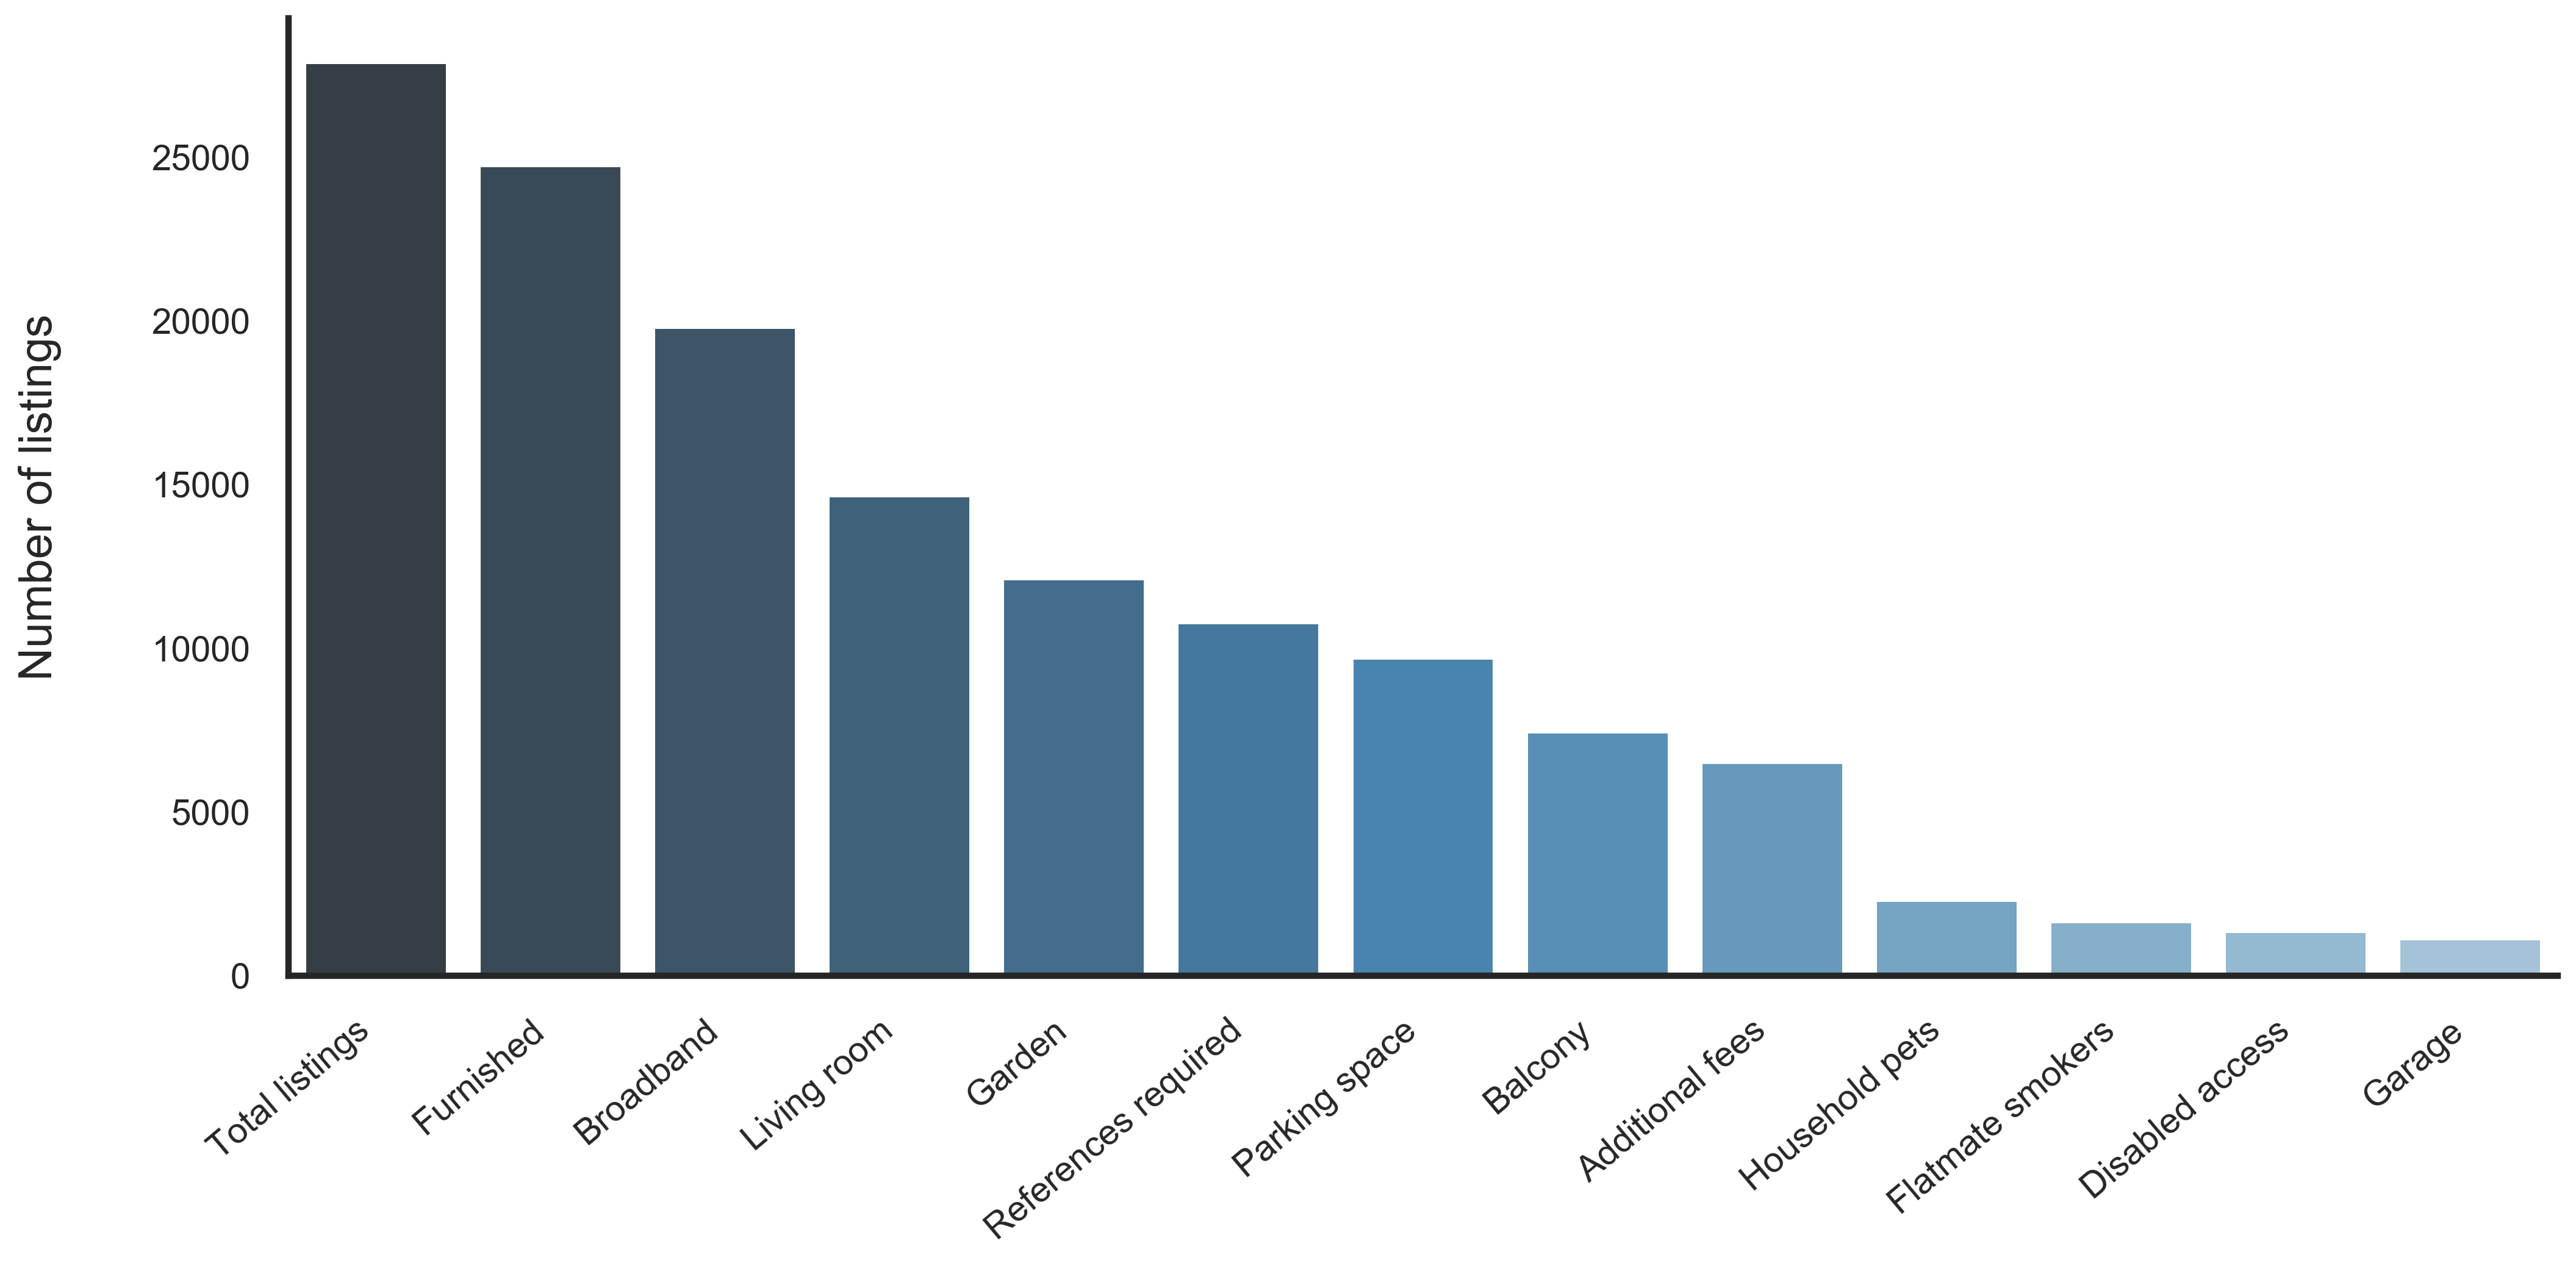

In [11]:
# Get amenities of the listings

amenities_list = ['balcony_patio','broadband',
                  'diasbled_access', 'fees_apply',
                  'flatmate_smokers','furnishings',
                  'garage', 'garden_terrace', 'household_pets',
                  'living_room', 'parking', 'references']

amenities = pd.Series(index=amenities_list)
amenities['Total listings'] = 27843
    
for category in amenities_list:
    if category == 'furnishings':
        amenities[category] = df[category].value_counts().to_dict()['Furnished']
    elif category == 'living_room':
        amenities[category] = df[category].value_counts().to_dict()['shared']
    else:
        amenities[category] = df[category].value_counts().to_dict()['Yes']
            
amenities = amenities.sort_values(ascending=False)

# Plot the typical amenities advertised with each listing

from matplotlib import gridspec

fig = plt.figure(figsize=(16,8), dpi=300)
gs = gridspec.GridSpec(2, 1, height_ratios=[1,0.05], width_ratios=[1]) 
ax = plt.subplot(gs[0])
amen_plot = sns.barplot(y=amenities, x=amenities.index, palette="Blues_d", ax=ax)

labels = ['Total listings', 'Furnished', 'Broadband', 'Living room', 'Garden', 'References required', 'Parking space',
         'Balcony', 'Additional fees', 'Household pets', 'Flatmate smokers', 'Disabled access', 'Garage']

amen_plot.set_xticklabels(labels=labels,rotation=40, ha='right')

amen_plot.set_ylabel('Number of listings', fontsize=18)
amen_plot.tick_params(labelsize=14)
amen_plot.axes.tick_params(pad=15)
amen_plot.xaxis.set_label_coords(0.5, -0.1)
amen_plot.yaxis.set_label_coords(-0.1, 0.5)
amen_plot.spines['bottom'].set_linewidth(2.5)
amen_plot.spines['left'].set_linewidth(2.5)

amen_plot.spines['top'].set_visible(False)
amen_plot.spines['right'].set_visible(False)

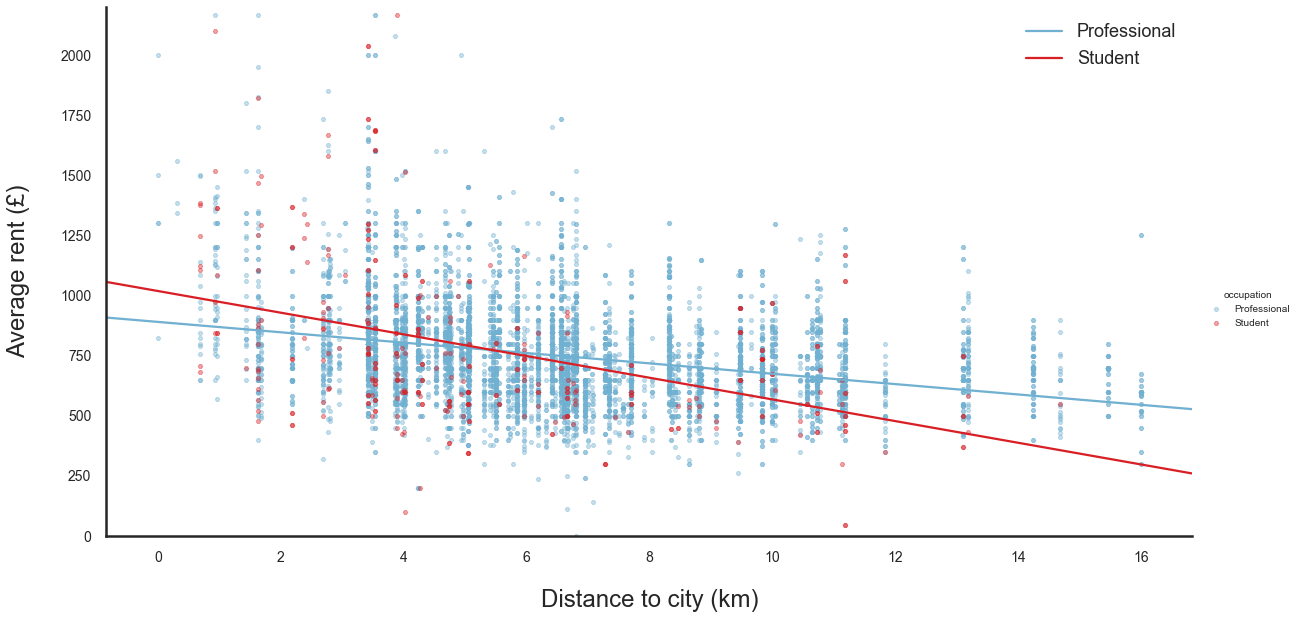

In [17]:
# Plot rent as a function of the occupation of the new tenant
remove_empty_cells = df[df['occupation'] != '']

dummy = pd.get_dummies(remove_empty_cells['occupation'], drop_first=False)
remove_empty_cells = pd.concat([remove_empty_cells, dummy], axis=1)

columns = ['average_rent', 'normalised_rent'] + list(dummy.columns)
grouped = remove_empty_cells.groupby('occupation').mean()

ax = sns.lmplot(x='distance_to_city', y='average_rent',size=8, aspect=2, 
                hue_order = ['Professional', 'Student'], 
                palette=[(0.44,0.69,0.82),(0.85,0.12,0.15)],
                markers='H', hue='occupation', data=df, 
                scatter_kws={'s':20, 'alpha':0.4}, ci=None)

ax.set(ylim=(0, 2200))

plt.gca().set_xlabel('Distance to city (km)', fontsize=24)
plt.gca().set_ylabel('Average rent (£)', fontsize=24)
plt.gca().tick_params(labelsize=14, pad=15)
plt.gca().xaxis.set_label_coords(0.5, -0.1)
plt.gca().yaxis.set_label_coords(-0.07, 0.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.gca().spines['left'].set_linewidth(2.5)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().legend(["Professional","Student", ], fontsize=18)

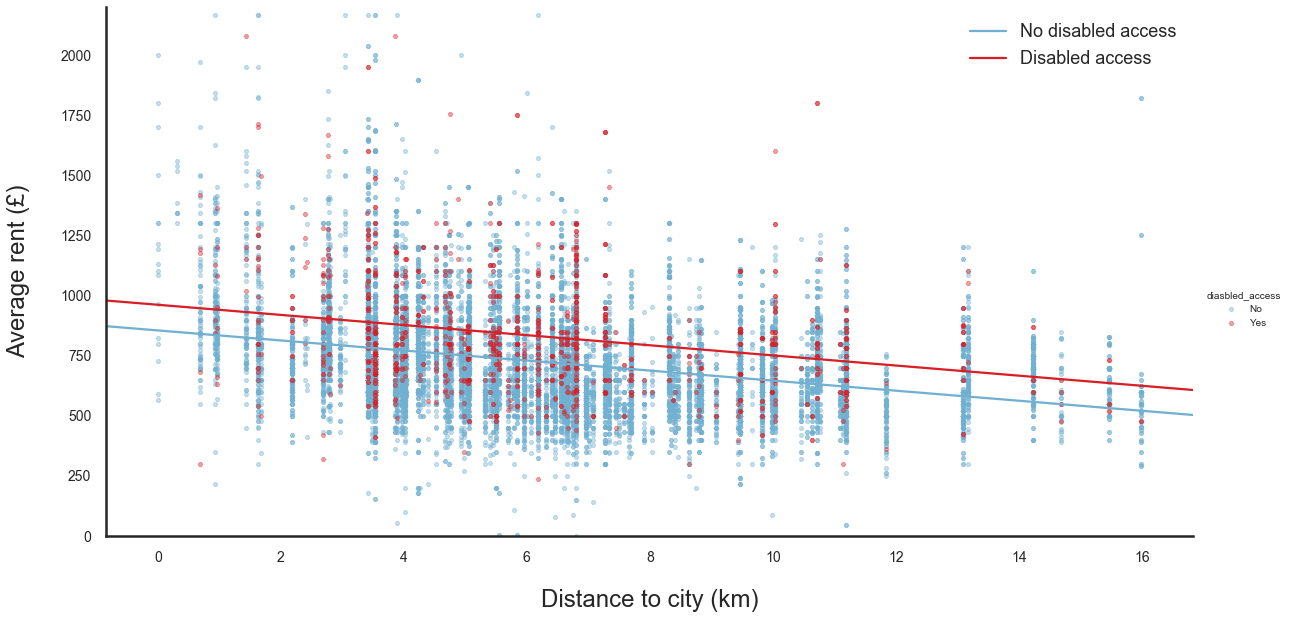

In [21]:
# Plot the difference in rent for disabled friendly listings
remove_empty_cells = df[df['diasbled_access'] != '']

dummy = pd.get_dummies(remove_empty_cells['diasbled_access'], drop_first=True)
remove_empty_cells = pd.concat([remove_empty_cells, dummy], axis=1)

columns = ['average_rent', 'normalised_rent'] + list(dummy.columns)
grouped = remove_empty_cells.groupby('diasbled_access').mean()

ax = sns.lmplot(x='distance_to_city', y='average_rent',size=8, aspect=2, 
                hue_order = ['No', 'Yes'], 
                palette=[(0.44,0.69,0.82),(0.85,0.12,0.15)],
                markers='H', hue='diasbled_access', data=df, 
                scatter_kws={'s':20, 'alpha':0.4}, ci=None)

ax.set(ylim=(0, 2200))

plt.gca().set_xlabel('Distance to city (km)', fontsize=24)
plt.gca().set_ylabel('Average rent (£)', fontsize=24)
plt.gca().tick_params(labelsize=14, pad=15)
plt.gca().xaxis.set_label_coords(0.5, -0.1)
plt.gca().yaxis.set_label_coords(-0.07, 0.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.gca().spines['left'].set_linewidth(2.5)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().legend(["No disabled access","Disabled access", ], fontsize=18)